<a href="https://colab.research.google.com/github/Synaptic-Sparks/synaptic-sparks-code/blob/main/xAI_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Download and Extraction

This section of the code automatically downloads the dataset from a public
Google Drive link and extracts it into the Google Colab runtime.

**Why this is needed:**
- Google Colab sessions are temporary and start empty each time.
- The dataset is not stored in the GitHub repository due to size limits.
- Downloading the dataset programmatically ensures reproducibility and allows
  anyone (e.g., the professor) to run the notebook without manual setup.

**Steps performed:**
1. Install `gdown`, a utility for downloading files from Google Drive.
2. Download the dataset ZIP file using its Google Drive file ID.
3. Verify that the downloaded file is valid by checking its size.
4. Unzip the dataset into the Colab filesystem for use in training and analysis.



In [2]:
!pip install -q gdown
import gdown
FILE_ID = "1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i"
OUTPUT = "/content/ImageNetSubset.zip"

gdown.download(
    f"https://drive.google.com/uc?id={FILE_ID}",
    OUTPUT,
    quiet=False
)

!unzip -q ImageNetSubset.zip -d /content/dataset

Downloading...
From (original): https://drive.google.com/uc?id=1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i
From (redirected): https://drive.google.com/uc?id=1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i&confirm=t&uuid=d5cc8ea1-b121-41c7-87b4-a9b3712986c5
To: /content/ImageNetSubset.zip
100%|██████████| 1.29G/1.29G [00:23<00:00, 55.5MB/s]


### Data Augmentation Visualization

This section demonstrates how data augmentation is applied to training images
using TensorFlow's `ImageDataGenerator`. Data augmentation artificially increases
the diversity of the training dataset by applying random transformations to
existing images. This helps improve model generalization and reduces overfitting.

In this example, a single image from the dataset is augmented multiple times,
and the resulting transformed images are displayed in a grid.


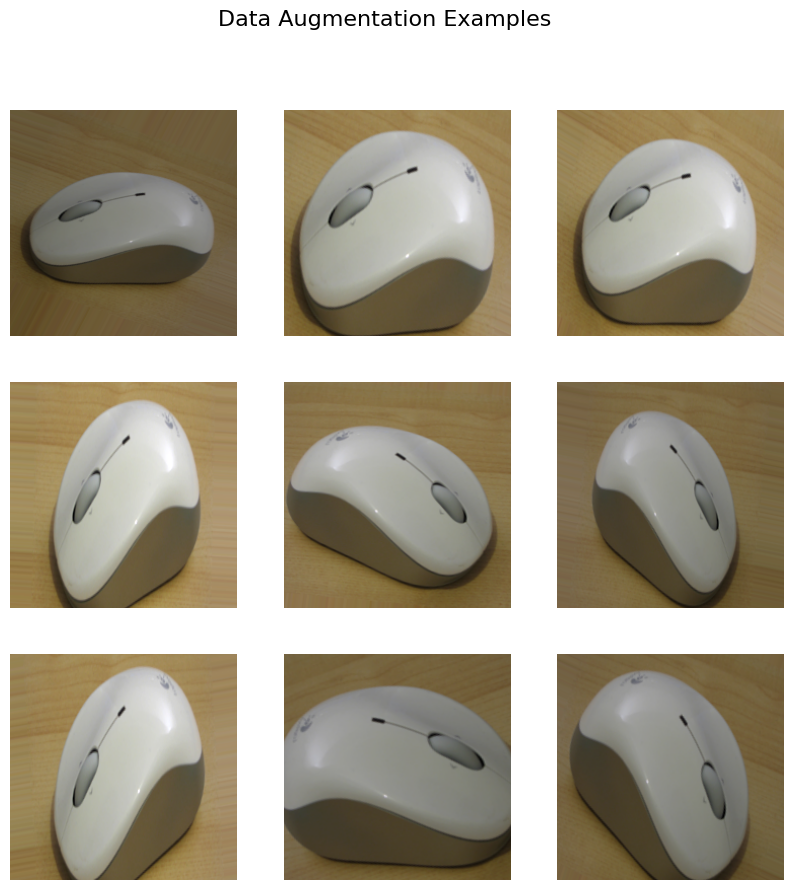

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image

sample_image_path = "/content/dataset/ImageNetSubset/train/mouse/n03793489_901.JPEG"

img = np.array(Image.open(sample_image_path).resize((224, 224)))

datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

img = img.reshape((1,) + img.shape)

aug_iter = datagen.flow(img, batch_size=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    batch = next(aug_iter)
    aug_img = batch[0].astype("uint8")
    plt.subplot(3, 3, i+1)
    plt.imshow(aug_img)
    plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=16)
plt.show()

### Class Distribution Analysis of the Training Dataset

This section analyzes the distribution of images across different classes
in the training dataset. Understanding class distribution is important because
imbalanced datasets can bias the model toward classes with more samples, which
can negatively impact classification performance.

The code counts the number of images in each class directory and visualizes
the results using a bar chart. This allows for a quick assessment of whether
the dataset is balanced or skewed toward certain classes.


toilet_tissue: 1300 images
binder: 1300 images
mouse: 1300 images
coffee_mug: 1300 images
wooden_spoon: 1300 images
soup_bowl: 1300 images
teapot: 1300 images
notebook: 1300 images
remote_control: 1300 images
computer_keyboard: 1300 images


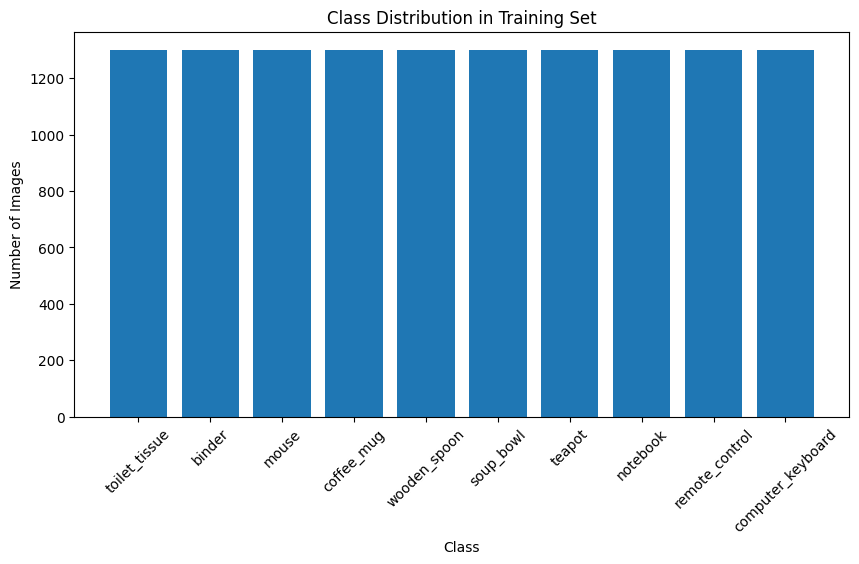

In [9]:
import os
import matplotlib.pyplot as plt

train_dir = "/content/dataset/ImageNetSubset/train"
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Display class counts
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Bar plot
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


### Feature Visualization Using a Pretrained CNN and PCA

This section visualizes high-level image features extracted by a pretrained
MobileNetV2 model. Instead of using the network for classification, the model
is used as a feature extractor to obtain compact representations of images.

Principal Component Analysis (PCA) is then applied to reduce the high-dimensional
feature vectors to two dimensions, allowing visualization of how images from
different classes are distributed in feature space. This helps assess whether
the pretrained model learns separable representations for the dataset classes.


/tmp/ipython-input-2377843260.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


Found 13000 images belonging to 10 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 674ms/step


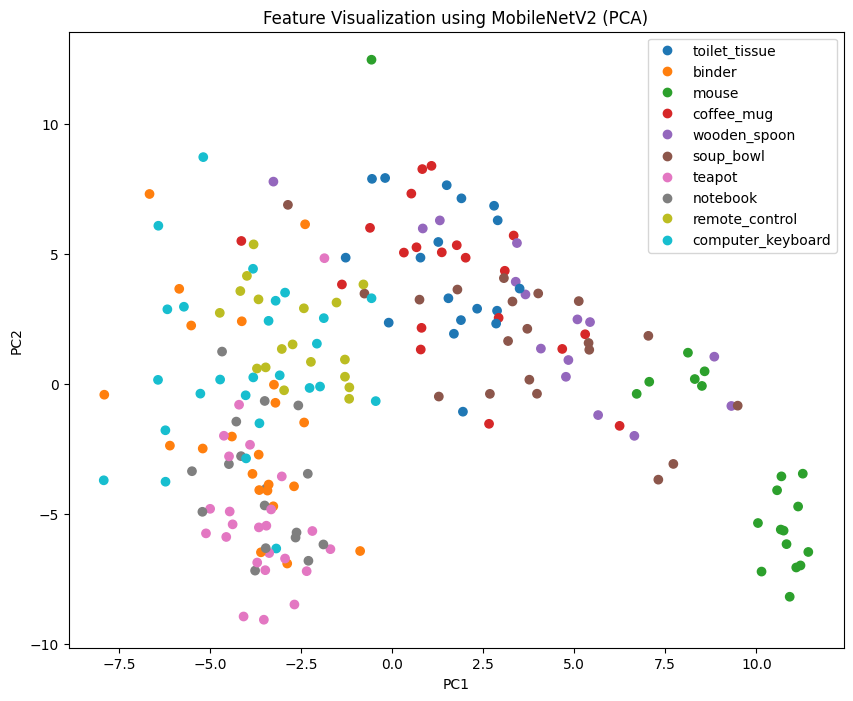

In [10]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

IMG_SIZE = 224

# Load pretrained MobileNetV2 up to the feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Load some samples from train set
datagen = ImageDataGenerator(rescale=1./255)
sample_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=200,   # 200 sample images for visualization
    shuffle=True
)

images, labels = next(sample_data)
features = base_model.predict(images)

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot reduced features
plt.figure(figsize=(10,8))
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=np.argmax(labels, axis=1), cmap='tab10')
plt.legend(scatter.legend_elements()[0], list(class_counts.keys()))
plt.title("Feature Visualization using MobileNetV2 (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

train_dir = "/content/dataset/ImageNetSubset/train"
test_dir  = "/content/dataset/ImageNetSubset/val"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False   # freeze pretrained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 221s 498ms/step - accuracy: 0.7567 - loss: 0.7406 - val_accuracy: 0.8320 - val_loss: 0.5086
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 178s 437ms/step - accuracy: 0.8748 - loss: 0.3758 - val_accuracy: 0.8540 - val_loss: 0.4771
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 180s 442ms/step - accuracy: 0.8884 - loss: 0.3252 - val_accuracy: 0.8400 - val_loss: 0.5091
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 175s 430ms/step - accuracy: 0.8947 - loss: 0.3094 - val_accuracy: 0.8460 - val_loss: 0.5141
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 176s 432ms/step - accuracy: 0.9014 - loss: 0.2794 - val_accuracy: 0.8120 - val_loss: 0.5836
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 174s 427ms/step - accuracy: 0.9061 - loss: 0.2776 - val_accuracy: 0.8440 - val_loss: 0.5272
Epoch 7/10
184/407 ━━━━━━━━━━━━━━━━━━━━ 1:35 427ms/step - accuracy: 0.9084 - loss: 0.2630

### Transfer Learning with MobileNetV2

This code uses a pretrained MobileNetV2 model for classifying our dataset.  
- **Data:** Images are resized to `224×224` (`target_size`) and processed in batches of 32 (`batch_size`). Pixel values are rescaled to `[0,1]`.  
- **Model:** The MobileNetV2 base is frozen (`trainable=False`) and a new classification head is added with global average pooling, a dense layer, dropout, and a softmax output.  
- **Training:** The model is compiled with `adam` optimizer and `categorical_crossentropy` loss, then trained for 10 epochs with validation.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_data, validation_data=test_data, epochs=10)


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - accuracy: 0.8062 - loss: 0.6005 - val_accuracy: 0.8460 - val_loss: 0.4888
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 48s 118ms/step - accuracy: 0.9163 - loss: 0.2440 - val_accuracy: 0.8420 - val_loss: 0.5449
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 47s 115ms/step - accuracy: 0.9385 - loss: 0.1756 - val_accuracy: 0.8560 - val_loss: 0.5272
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 50s 124ms/step - accuracy: 0.9488 - loss: 0.1436 - val_accuracy: 0.8440 - val_loss: 0.5670
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 45s 111ms/step - accuracy: 0.9547 - loss: 0.1226 - val_accuracy: 0.8280 - val_loss: 0.6637
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.9623 - loss: 0.0989 - val_accuracy: 0.8400 - val_loss: 0.6520
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 45s 110ms/step - accuracy: 0.9675 - loss: 0.0834 - val_accuracy: 0.8340 - val_loss: 0.7410
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 47s 114ms/step - accuracy: 0.9736 - loss: 0

### Training Performance Visualization

This section plots the model's performance over training epochs.  

- **Left plot:** Shows training and validation accuracy, allowing us to see how well the model is learning and whether it generalizes to unseen data.  
- **Right plot:** Shows training and validation loss, indicating how the model's error decreases over time.  

These visualizations help identify issues like **overfitting** or **underfitting** and evaluate the effectiveness of the transfer learning setup with MobileNetV2.


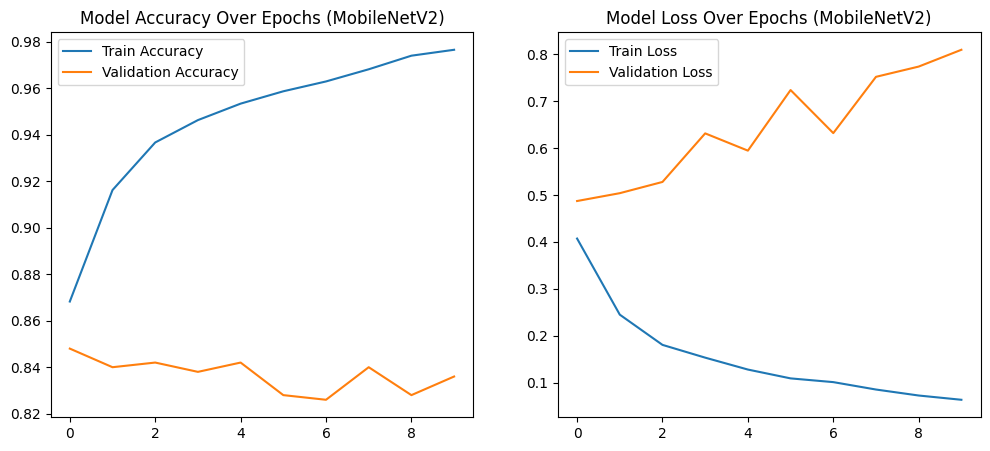

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs (MobileNetV2)")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs (MobileNetV2)")
plt.legend()

plt.show()


In [3]:
!pip install -q gdown
import gdown
FILE_ID = "1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K"
OUTPUT = "/content/xai-imagenet10-hard-test.zip"

gdown.download(
    f"https://drive.google.com/uc?id={FILE_ID}",
    OUTPUT,
    quiet=False
)

!unzip -q xai-imagenet10-hard-test.zip -d /content/dataset

Downloading...
From (original): https://drive.google.com/uc?id=1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K
From (redirected): https://drive.google.com/uc?id=1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K&confirm=t&uuid=d3a8a425-1c2d-4d37-ac69-4e124dbef1ef
To: /content/xai-imagenet10-hard-test.zip
100%|██████████| 1.47G/1.47G [00:26<00:00, 55.5MB/s]


### Custom Dataset Evaluation
This code loads test images, resizes them to 224×224, and normalizes pixel values.
The trained model is evaluated on this dataset, and the final accuracy is printed to show how well the model performs on new images.

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

# Load custom test dataset
custom_datagen = ImageDataGenerator(rescale=1./255)

custom_test_data = custom_datagen.flow_from_directory(
    "/content/dataset/xai-imagenet10-hard-test",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions (single pass)
y_prob = model.predict(custom_test_data, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = custom_test_data.classes

# Compute accuracy manually
accuracy = np.mean(y_pred == y_true)
print(f"Custom Dataset Accuracy: {accuracy*100:.2f}%")

# Compute loss manually (optional)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=custom_test_data.num_classes)
loss = loss_fn(y_true_one_hot, y_prob).numpy()
print(f"Custom Dataset Loss: {loss:.4f}")

# Get confidence scores (max softmax probability)
confidence = np.max(y_prob, axis=1)



Found 4409 images belonging to 10 classes.
138/138 ━━━━━━━━━━━━━━━━━━━━ 137s 997ms/step
Custom Dataset Accuracy: 41.80%
Custom Dataset Loss: 3.7521


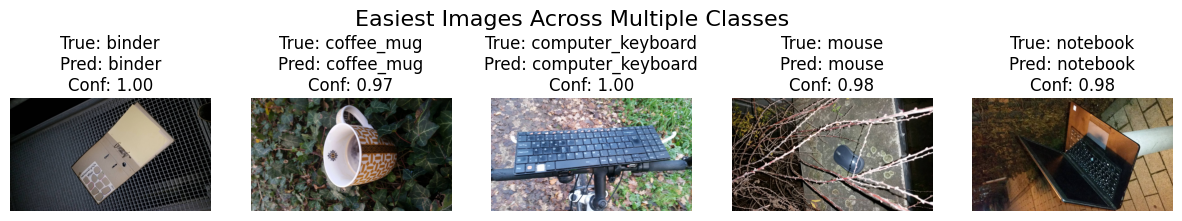

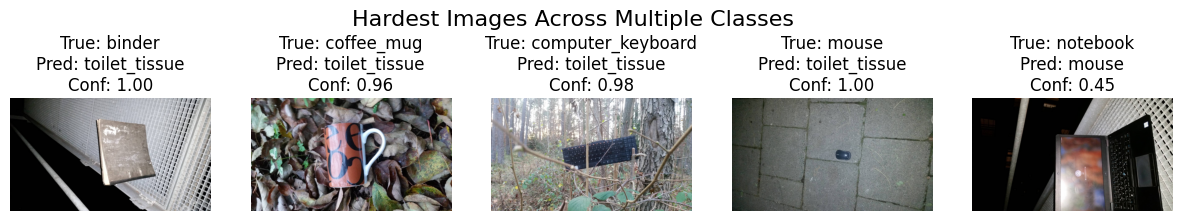

['/content/dataset/xai-imagenet10-hard-test/binder/BLNH_SG5_binder_004.jpg',
 '/content/dataset/xai-imagenet10-hard-test/coffee_mug/BLNH_SG5_coffee-mug_001.jpg',
 '/content/dataset/xai-imagenet10-hard-test/computer_keyboard/BLNH_SG5_computer-keyboard_002.jpg',
 '/content/dataset/xai-imagenet10-hard-test/mouse/BLNH_SG5_mouse_002.jpg',
 '/content/dataset/xai-imagenet10-hard-test/notebook/BLNH_SG5_notebook_001.jpg']

In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_balanced_indices(condition_fn, y_true, max_per_class=1, max_total=5):
    selected = []
    class_count = defaultdict(int)

    for idx in range(len(y_true)):
        if condition_fn(idx):
            cls = y_true[idx]
            if class_count[cls] < max_per_class:
                selected.append(idx)
                class_count[cls] += 1
        if len(selected) >= max_total:
            break

    return selected
# Get filepaths and class names from the generator
filepaths = custom_test_data.filepaths
class_names = list(custom_test_data.class_indices.keys())

easy_indices = get_balanced_indices(
    condition_fn=lambda i: (y_pred[i] == y_true[i]) and (confidence[i] > 0.9),
    y_true=y_true,
    max_per_class=1,
    max_total=5
)
hard_indices = get_balanced_indices(
    condition_fn=lambda i: (y_pred[i] != y_true[i]) or (confidence[i] < 0.4),
    y_true=y_true,
    max_per_class=1,
    max_total=5
)

def show_image_grid(indices, title, filepaths, y_true, y_pred, confidence, class_names):
    n = len(indices)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = mpimg.imread(filepaths[idx])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}\nConf: {confidence[idx]:.2f}")
    plt.suptitle(title, fontsize=16)
    plt.show()


show_image_grid(
    easy_indices,
    title="Easiest Images Across Multiple Classes",
    filepaths=filepaths,
    y_true=y_true,
    y_pred=y_pred,
    confidence=confidence,
    class_names=class_names
)

show_image_grid(
    hard_indices,
    title="Hardest Images Across Multiple Classes",
    filepaths=filepaths,
    y_true=y_true,
    y_pred=y_pred,
    confidence=confidence,
    class_names=class_names
)

hard_images = [filepaths[i] for i in hard_indices]
hard_images


### Model Calibration Curve (Confidence vs Accuracy)
This code evaluates how well the model’s predicted confidence matches its actual performance.
Predictions are marked as correct (1) or incorrect (0), then grouped into confidence bins.
For each bin, the plot compares average predicted confidence (x-axis) with true accuracy (y-axis).
The dashed diagonal represents perfect calibration—points below it indicate overconfidence, and points above it indicate underconfidence.

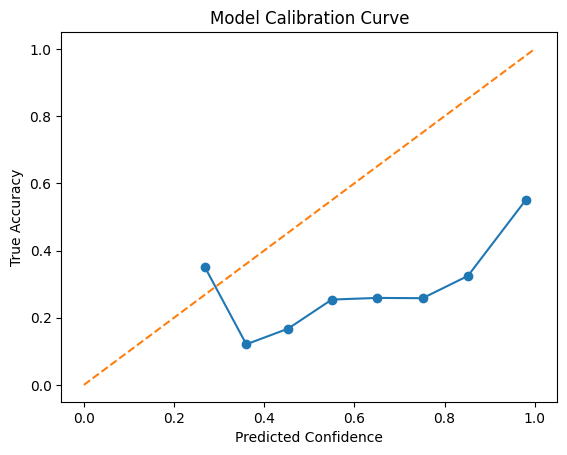

In [31]:
# @title
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

true_binary = (y_pred == y_true).astype(int)
prob_true, prob_pred = calibration_curve(true_binary, confidence, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Confidence")
plt.ylabel("True Accuracy")
plt.title("Model Calibration Curve")
plt.show()


In [32]:
ambiguous = np.where((y_pred != y_true) & (confidence > 0.8))[0][:10]

for idx in ambiguous:
    print("Image:", filepaths[idx])
    print("True:", custom_test_data.class_indices)
    print("Predicted class:", list(custom_test_data.class_indices.keys())[y_pred[idx]])
    print("Confidence:", confidence[idx])
    print("------")


Image: /content/dataset/xai-imagenet10-hard-test/binder/BLNH_SG5_binder_004.jpg
True: {'binder': 0, 'coffee_mug': 1, 'computer_keyboard': 2, 'mouse': 3, 'notebook': 4, 'remote_control': 5, 'soup_bowl': 6, 'teapot': 7, 'toilet_tissue': 8, 'wooden_spoon': 9}
Predicted class: toilet_tissue
Confidence: 0.9999337
------
Image: /content/dataset/xai-imagenet10-hard-test/binder/BLNH_SG5_binder_005.jpg
True: {'binder': 0, 'coffee_mug': 1, 'computer_keyboard': 2, 'mouse': 3, 'notebook': 4, 'remote_control': 5, 'soup_bowl': 6, 'teapot': 7, 'toilet_tissue': 8, 'wooden_spoon': 9}
Predicted class: computer_keyboard
Confidence: 0.9508525
------
Image: /content/dataset/xai-imagenet10-hard-test/binder/BLNH_SG5_binder_010.jpg
True: {'binder': 0, 'coffee_mug': 1, 'computer_keyboard': 2, 'mouse': 3, 'notebook': 4, 'remote_control': 5, 'soup_bowl': 6, 'teapot': 7, 'toilet_tissue': 8, 'wooden_spoon': 9}
Predicted class: toilet_tissue
Confidence: 0.99921024
------
Image: /content/dataset/xai-imagenet10-hard-

In [33]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def gradcam(model, img_path, class_index=None, layer_name=None):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Ensure Sequential model is built
    if isinstance(model, tf.keras.Sequential) and not model.built:
        model.build(img_array.shape)

    # Auto-detect last conv layer if not provided
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
    if layer_name is None:
        raise ValueError("No Conv2D layer found for Grad-CAM.")

    # Grad-CAM computation
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    # Overlay heatmap on image
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, (224, 224))
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Grad-CAM for class {class_index}")
    plt.show()

# Example usage:
# Ensure your model is loaded first
# gradcam(model, "path_to_your_image.jpg")


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_475']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


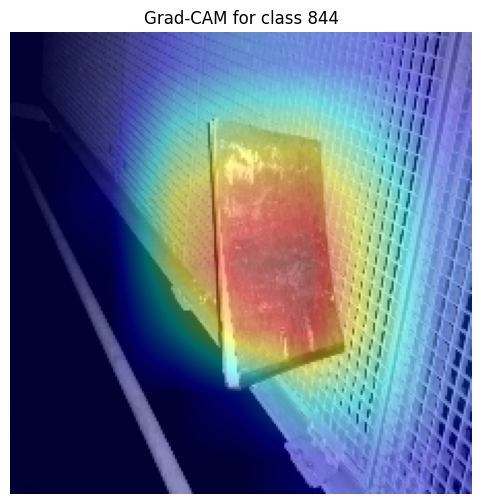

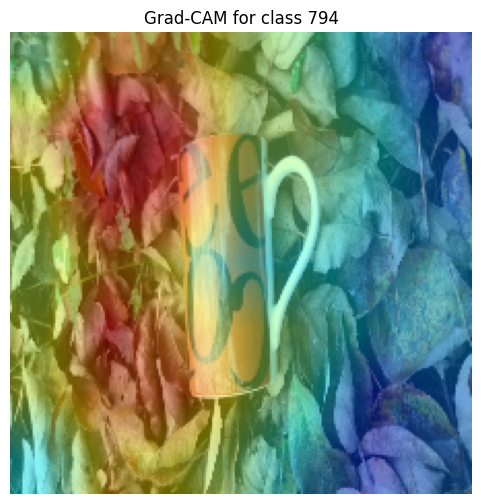

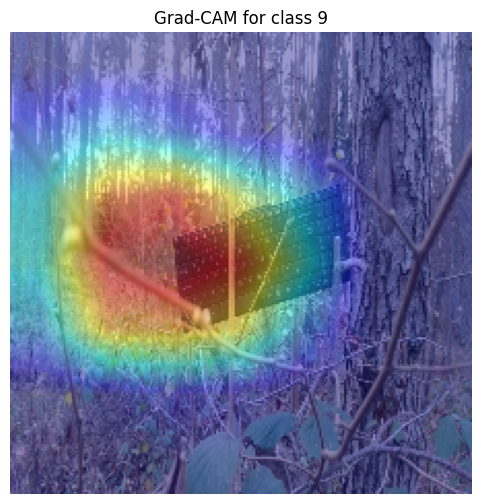

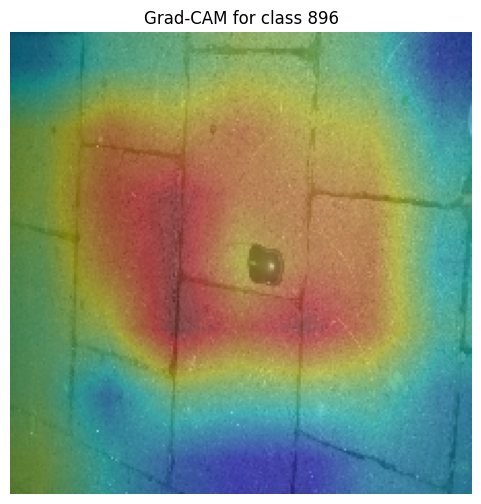

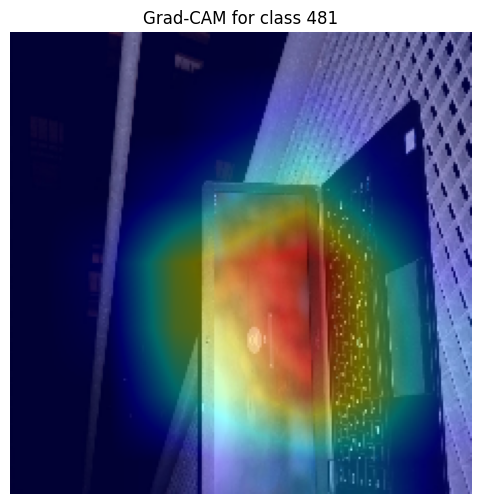

In [34]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=True)

# Use the base model for Grad-CAM
gradcam(base_model, hard_images[0])
gradcam(base_model, hard_images[1])
gradcam(base_model, hard_images[2])
gradcam(base_model, hard_images[3])
gradcam(base_model, hard_images[4])

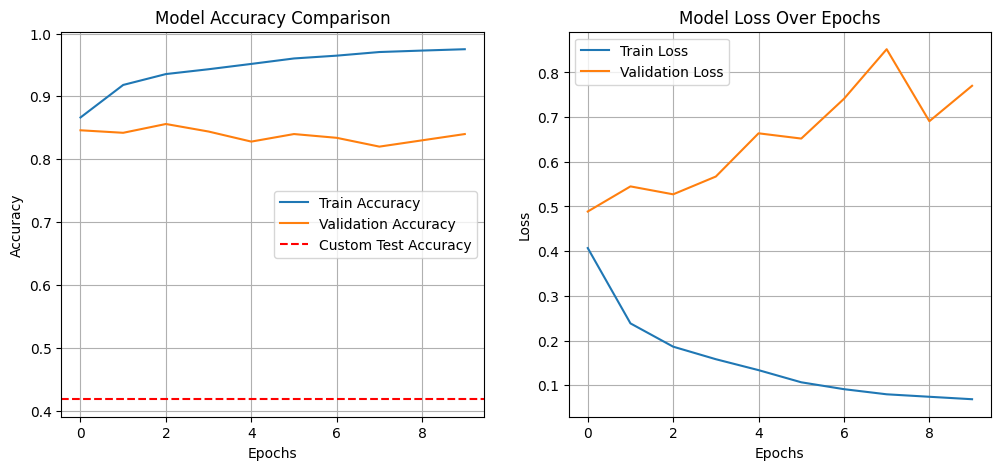

In [39]:
import matplotlib.pyplot as plt
# -----------------------------
# 2. Plot training, validation, and custom test metrics
# -----------------------------
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Custom Test Accuracy')
plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


138/138 ━━━━━━━━━━━━━━━━━━━━ 137s 994ms/step
Custom Dataset Accuracy: 41.80%
Custom Dataset Loss: 3.7521


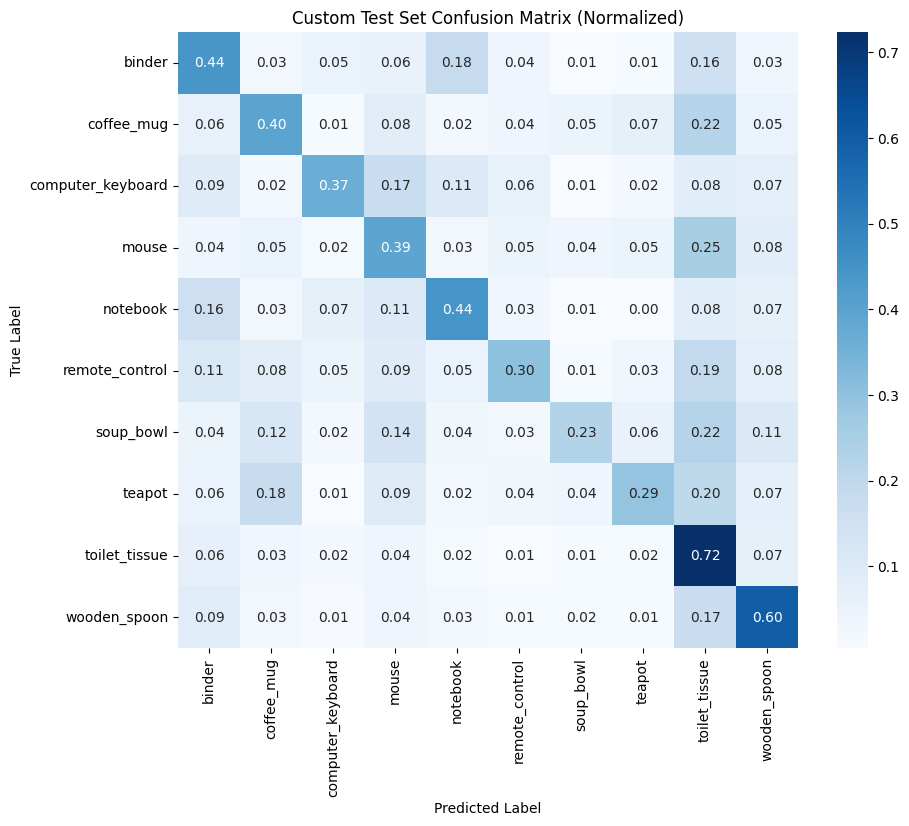

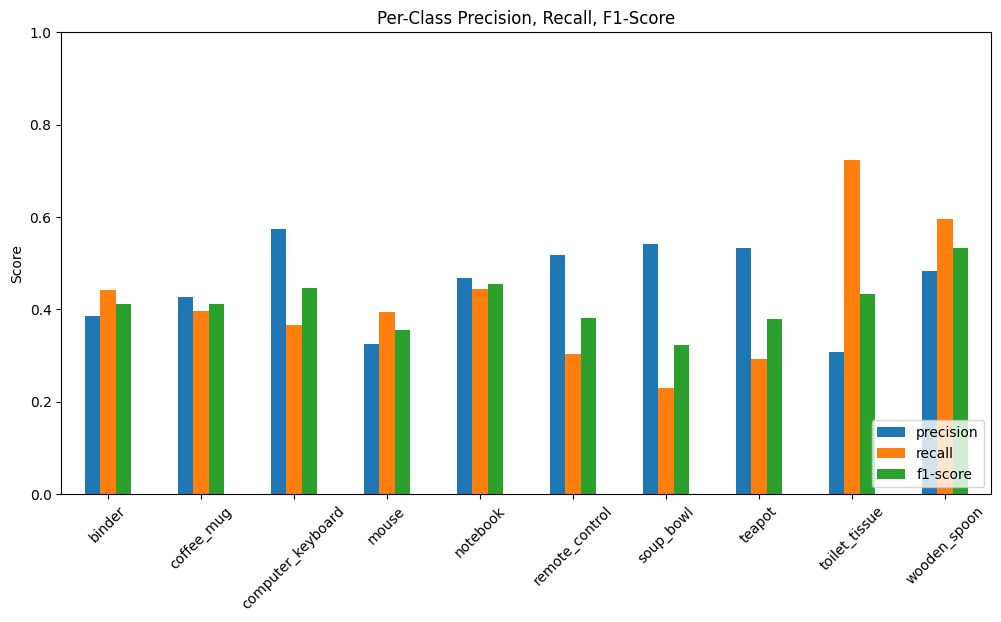

                   precision    recall  f1-score      support
binder              0.385519  0.442697  0.412134   445.000000
coffee_mug          0.426267  0.396996  0.411111   466.000000
computer_keyboard   0.573529  0.365340  0.446352   427.000000
mouse               0.324528  0.393593  0.355739   437.000000
notebook            0.466830  0.444965  0.455635   427.000000
remote_control      0.516854  0.302632  0.381743   456.000000
soup_bowl           0.541436  0.228972  0.321839   428.000000
teapot              0.532000  0.293598  0.378378   453.000000
toilet_tissue       0.308448  0.723502  0.432507   434.000000
wooden_spoon        0.482375  0.596330  0.533333   436.000000
accuracy            0.418009  0.418009  0.418009     0.418009
macro avg           0.455779  0.418862  0.412877  4409.000000
weighted avg        0.455624  0.418009  0.412577  4409.000000


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

# -------------------------------
# Single-pass evaluation on custom test set
# -------------------------------

# Predict once
y_prob_custom = model.predict(custom_test_data, verbose=1)
y_pred_custom = np.argmax(y_prob_custom, axis=1)
y_true_custom = custom_test_data.classes
confidence_custom = np.max(y_prob_custom, axis=1)
class_names_custom = list(custom_test_data.class_indices.keys())

# Compute overall accuracy
accuracy_custom = np.mean(y_pred_custom == y_true_custom)
print(f"Custom Dataset Accuracy: {accuracy_custom*100:.2f}%")

# Compute loss (optional)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
y_true_one_hot_custom = tf.keras.utils.to_categorical(
    y_true_custom, num_classes=custom_test_data.num_classes
)
loss_custom = loss_fn(y_true_one_hot_custom, y_prob_custom).numpy()
print(f"Custom Dataset Loss: {loss_custom:.4f}")

# -------------------------------
# Confusion Matrix (Normalized)
# -------------------------------
cm_custom = confusion_matrix(y_true_custom, y_pred_custom)
cm_custom_norm = cm_custom.astype('float') / cm_custom.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_custom_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names_custom, yticklabels=class_names_custom)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Custom Test Set Confusion Matrix (Normalized)")
plt.show()

# -------------------------------
# Classification report visualization
# -------------------------------
report_dict = classification_report(
    y_true_custom, y_pred_custom, target_names=class_names_custom, output_dict=True
)

# Convert to DataFrame for plotting
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.iloc[:-3, :]  # exclude 'accuracy', 'macro avg', 'weighted avg' rows if you want only per-class

# Plot Precision, Recall, F1-score per class
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title("Per-Class Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

# Optional: print full table including accuracy, macro avg, weighted avg
print(pd.DataFrame(report_dict).transpose())


### RESNET50



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. FIXED: Use ResNet50's specific preprocessing instead of 1./255
res_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
res_test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_res = res_train_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data_res = res_test_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/val",
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# 2. Build Model (Same as before)
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_base.trainable = False

resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data_res.num_classes, activation='softmax')
])

# 3. Compile and Train
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""resnet_history = resnet_model.fit(
    train_data_res,
    validation_data=test_data_res,
    epochs=10
)"""

# Speed-up example
resnet_history = resnet_model.fit(
    train_data_res,
    validation_data=test_data_res,
    epochs=5,             # Reduce epochs from 10 to 5
    steps_per_epoch=100   # Only look at 100 batches per epoch
)

import pandas as pd

results = pd.DataFrame({
    "Model": ["MobileNetV2", "ResNet50"],
    "Test Accuracy": [acc, resnet_acc]
})

results
plt.plot(history.history['val_accuracy'], label="MobileNetV2")
plt.plot(resnet_history.history['val_accuracy'], label="ResNet50")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 27/100 ━━━━━━━━━━━━━━━━━━━━ 7:01 6s/step - accuracy: 0.4425 - loss: 1.8266